# Основные задачи автоматической обработки текста
## 2 - DA 

In [2]:
import xml.etree.ElementTree as ET
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import normalize
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from inspect import signature
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

Вынем нужные данные из xml-файлов.

In [3]:
textdir = 'Text'
nontextdir = 'Nontext'
feature_names = ['BlackCount', 'WhiteHolesCount', 'HorzStrokesCount', 'VertStrokesCount', 'MaxHorzStrokeLength']

def parse_data(folder, is_text):
    files = map(lambda x: folder + '/' + x, filter(lambda x: x.endswith('.xml'), os.listdir(folder)))
    
    arr = np.empty([0, 5])
    factors = np.empty([0, 1])

    for f in files:
        tree = ET.parse(f)
        root = tree.getroot()
        for fragment in root.iter('WordFragment'):
            if fragment.get('IsVertical') == 'true':
                continue
            row = np.array([int(fragment.get(f)) for f in feature_names])
            coords = fragment.find('Rect').attrib
            width = int(coords['Right']) - int(coords['Left'])
            height = int(coords['Bottom']) - int(coords['Top'])
            square = width * height
            factors = np.vstack([factors, square])
            arr = np.vstack([arr, row])
    if is_text:
        labels = np.ones([arr.shape[0],])
    else:
        labels = np.zeros([arr.shape[0],])
    return arr, factors, labels

text, text_factors, text_labels = parse_data(textdir, True)
ntext, ntext_factors, ntext_labels = parse_data(nontextdir, False)

In [4]:
Xraw = np.vstack([text, ntext])
y = np.concatenate([text_labels, ntext_labels])
factors = np.vstack([text_factors, ntext_factors])

print(Xraw.shape)
print(y.shape)
print(factors.shape)

(19655, 5)
(19655,)
(19655, 1)


Чтобы данные не зависели от размера объектов, поделим их на площадь (в предположении, что количество объектов должно увеличиваться пропорционально площади).

In [5]:
X = Xraw / factors

Сгенерируем новые признаки, комбинируя старые.

In [7]:
poly = PolynomialFeatures(3)
X = poly.fit_transform(X)

Разделим датасет.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

И стандартизируем его - обычно модели лучше работают с такими данными.

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Подготовим функцию, рисующую графики `roc-auc` и `precision-recall` кривых, а также считающую соответствующие скоры + accuracy.

In [10]:
def plot_curves(y_test, y_score, probs):
    # Some scores
    print('Accuracy: ', accuracy_score(y_test, y_score))  
    
    average_precision = average_precision_score(y_test, probs)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    
    print('Roc-auc score: ', roc_auc_score(y_test, probs))
    
    # Pr-recall auc curve
    precision, recall, _ = precision_recall_curve(y_test, probs)

    
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    
    # Roc-auc curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

Далее везде постараемся делать хоть какой-нибудь гридсерч по параметрам модели для лучшей классификации - в некоторых алгоритмах они играют значительную роль.

# Linear SVC
В принципе, даже линейный SV классификатор достаточно хорошо справился с данными.
### Ошибки
- Возможно, слишком простая модель
- Возможно переобучение на большом кол-ве данных
- Не предоставляет по умолчанию вычисление вероятностей, пришлось использовать `CalibratedClassifierCV`

Accuracy:  0.834961334961335
Average precision-recall score: 0.91
Roc-auc score:  0.8988874415408531


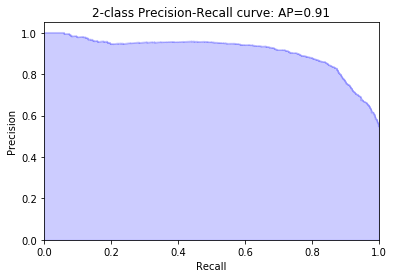

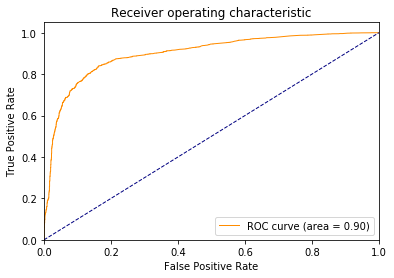

In [11]:
linSVC = LinearSVC(dual=False)
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [1, 10, 100]
}

grid_clf = GridSearchCV(linSVC, param_grid, cv=5)
clf = CalibratedClassifierCV(grid_clf, cv=3) 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

plot_curves(y_test, y_pred, clf.predict_proba(X_test)[:, 1])

# KNN
Еще один пример относительно простой модели, справляющейся с поставленной задачей.
## Ошибки
- Плохо справляется с небалансированными данными, отдавая предпочтение более распространенному классу
- Его легко "ввести в заблуждение" случайным шумом 

Best parameters:  {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Accuracy:  0.8557183557183557
Average precision-recall score: 0.92
Roc-auc score:  0.9158666964660986


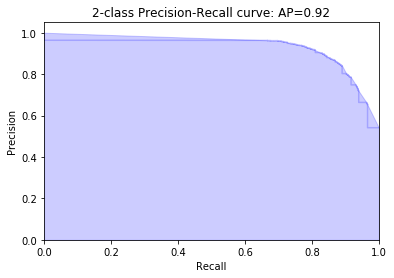

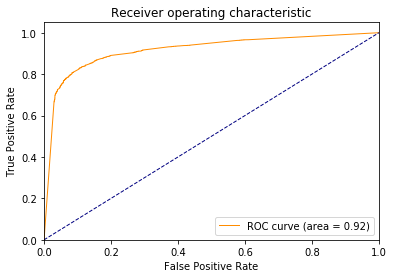

In [12]:
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': range(1, 10),
    'weights': ['uniform', 'distance'],
    'metric':  ['euclidean', 'manhattan']
}

grid_clf = GridSearchCV(knn, param_grid, cv=5)
grid_clf.fit(X_train, y_train)

print('Best parameters: ', grid_clf.best_params_)

y_pred = grid_clf.predict(X_test)

plot_curves(y_test, y_pred, grid_clf.predict_proba(X_test)[:, 1])

# XGBoost
Попробуем что-нибудь более тяжелое - методы бустинга. Призван справляться с аномалиями, несбалансируемостью датасета благодаря алгоритму работы - на каждом шаге корректирует ошибки предыдущей модели.
## Ошибки
- Легко переобучается
- Долго работает
- Тяжело подобрать оптимальные параметры, в том числе из-за пункта выше про время работы 
- Забавно, но дал всего такой же `accuracy`, как и просто knn. Зато roc и pr-rec получше.

Best parameters:  {'max_depth': 8, 'min_child_weight': 2}

Accuracy:  0.8557183557183557
Average precision-recall score: 0.95
Roc-auc score:  0.9367126778792588


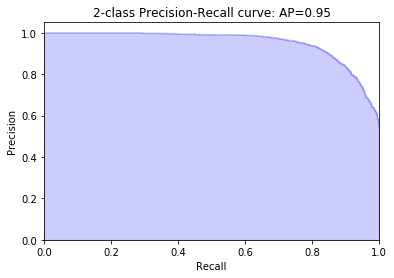

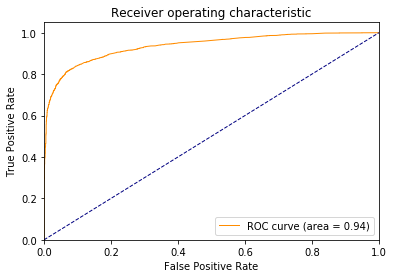

In [13]:
param_test1 = {
 'max_depth':range(4,10,2),
 'min_child_weight':range(2,6,2)
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(objective= 'binary:logistic', nthread=-1), 
                        param_grid = param_test1, n_jobs=-1, iid=False, cv=5)

gsearch1.fit(X_train, y_train)

print('Best parameters: ', gsearch1.best_params_)
print()

у_pred = gsearch1.predict(X_test)

plot_curves(y_test, y_pred, gsearch1.predict_proba(X_test)[:, 1])

# AdaBoost + RandomForest
Еще один бустинг, на этот раз вместе с forest'ом. Леса, да и AdaBoost, менее склонны к оверфиттингу. Accuracy получился лучше всего, но остальные две метрики просели.
## Ошибки
- Затратно по времени
- AdaBoost может быть восприимив к шуму

Accuracy:  0.8671143671143671
Average precision-recall score: 0.94
Roc-auc score:  0.9168609189344257


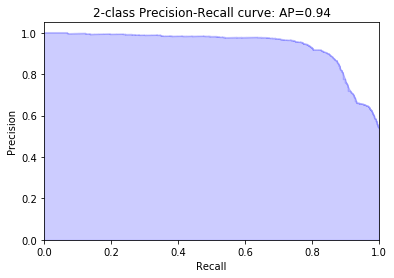

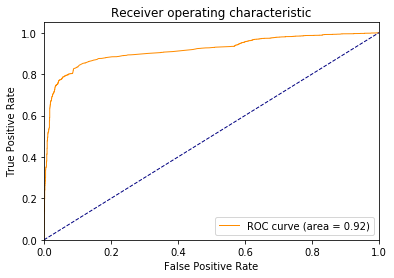

In [14]:
clf = AdaBoostClassifier(RandomForestClassifier(n_estimators=150), n_estimators=150)
clf.fit(X_train, y_train)  

y_pred = clf.predict(X_test)

plot_curves(y_test, y_pred, clf.predict_proba(X_test)[:, 1])